<a href="https://colab.research.google.com/github/PGV1000/data_mining/blob/main/%D0%9C%D0%B5%D0%B4%D0%B2%D0%B5%D0%B4%D0%B5%D0%B2_%D0%98%D0%97.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install pandas-datareader
!pip install nbeats-keras
!pip install plotly
!pip install pycountry
!pip install tensorflow
!pip install darts

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, GRU, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
from darts.models import NBEATSModel
from darts import TimeSeries
import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
import tensorflow.keras.backend as K
import warnings
warnings.filterwarnings('ignore')
import kagglehub

In [ ]:
# Download latest version
path = kagglehub.dataset_download("twinkle0705/state-wise-power-consumption-in-india")
!cp -r {path} .
print("Path to dataset files:", path)

100%|██████████| 123k/123k [00:00<00:00, 33.4MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/twinkle0705/state-wise-power-consumption-in-india/versions/3


In [ ]:
ds = pd.read_csv('/content/3/dataset_tk.csv')

ds.rename(columns={'Unnamed: 0': 'DateTime'}, inplace=True)
ds['DateTime'] = pd.to_datetime(ds['DateTime'], format='%d/%m/%Y %H:%M:%S')

data = ds['Delhi'].values.astype('float32').reshape(-1, 1)

print("Количество НАН в Дели:", np.isnan(data).sum())
print("Колифество беск в ДЕли:", np.isinf(data).sum())

data = data[~np.isnan(data).any(axis=1) & ~np.isinf(data).any(axis=1)]


scaler_target = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler_target.fit_transform(data)
print("минимальное значчение до скейла:", data.min())
print("Максимальное значение до скейла:", data.max())
print("минимальное значчение после скейла:", data_scaled.min())
print("Максимальное значчение после скейла:", data_scaled.max())
print("Стандартное отклонение:", np.std(data_scaled))

noise = np.random.normal(0, 0.01, data_scaled.shape)
data_scaled_noisy = np.clip(data_scaled + noise, 0, 1)
print("Стандартное отклонение после шума:", np.std(data_scaled_noisy))

train_size = int(len(data_scaled_noisy) * 0.8)
train, test = data_scaled_noisy[0:train_size, :], data_scaled_noisy[train_size:, :]

def create_sequences(dataset, look_back):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 6
X_train, Y_train = create_sequences(train, look_back)
X_test, Y_test = create_sequences(test, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print("X_train шейп:", X_train.shape)
print("Y_train шейп:", Y_train.shape)
print("X_test шейп:", X_test.shape)
print("Y_test шейп:", Y_test.shape)

Количество НАН в Дели: 0
Колифество беск в ДЕли: 0
минимальное значчение до скейла: 41.8
Максимальное значение до скейла: 147.1
минимальное значчение после скейла: 0.0
Максимальное значчение после скейла: 1.0
Стандартное отклонение: 0.24586497
Стандартное отклонение после шума: 0.24637706518611144
X_train шейп: (396, 6, 1)
Y_train шейп: (396,)
X_test шейп: (95, 6, 1)
Y_test шейп: (95,)


In [ ]:
from darts import TimeSeries


train_series = TimeSeries.from_values(train.flatten())
test_series = TimeSeries.from_values(test.flatten())

# Проверка длин
print("Размер обучающей выборки:", len(train_series))
print("Размер тестовой выборки:", len(test_series))

Размер обучающей выборки: 402
Размер тестовой выборки: 101


Epoch 1/30
13/13 - 3s - 226ms/step - loss: 0.0856 - val_loss: 0.0598
Epoch 2/30
13/13 - 0s - 13ms/step - loss: 0.0394 - val_loss: 0.0579
Epoch 3/30
13/13 - 0s - 23ms/step - loss: 0.0346 - val_loss: 0.0532
Epoch 4/30
13/13 - 0s - 24ms/step - loss: 0.0327 - val_loss: 0.0506
Epoch 5/30
13/13 - 0s - 29ms/step - loss: 0.0306 - val_loss: 0.0475
Epoch 6/30
13/13 - 0s - 25ms/step - loss: 0.0288 - val_loss: 0.0448
Epoch 7/30
13/13 - 0s - 20ms/step - loss: 0.0272 - val_loss: 0.0421
Epoch 8/30
13/13 - 0s - 22ms/step - loss: 0.0252 - val_loss: 0.0395
Epoch 9/30
13/13 - 0s - 27ms/step - loss: 0.0235 - val_loss: 0.0371
Epoch 10/30
13/13 - 0s - 19ms/step - loss: 0.0220 - val_loss: 0.0351
Epoch 11/30
13/13 - 0s - 26ms/step - loss: 0.0212 - val_loss: 0.0338
Epoch 12/30
13/13 - 0s - 22ms/step - loss: 0.0203 - val_loss: 0.0336
Epoch 13/30
13/13 - 0s - 22ms/step - loss: 0.0199 - val_loss: 0.0328
Epoch 14/30
13/13 - 0s - 17ms/step - loss: 0.0195 - val_loss: 0.0326
Epoch 15/30
13/13 - 0s - 16ms/step - loss:

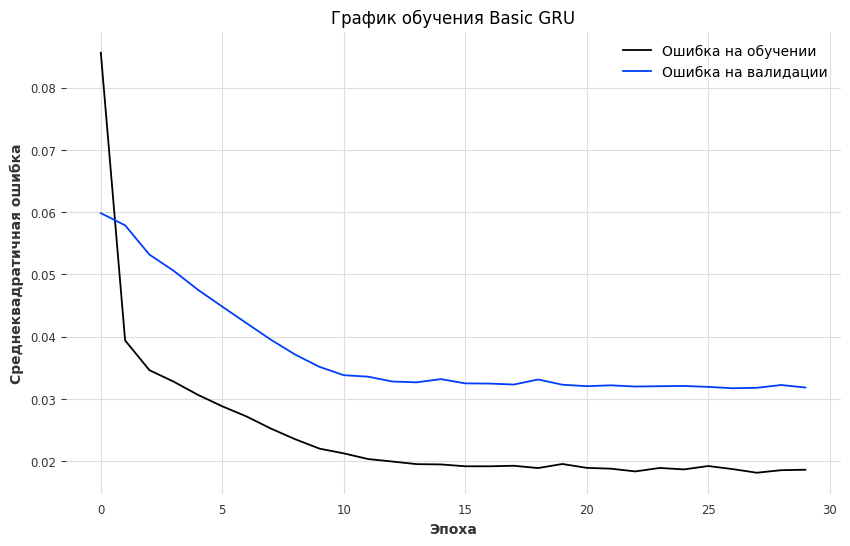

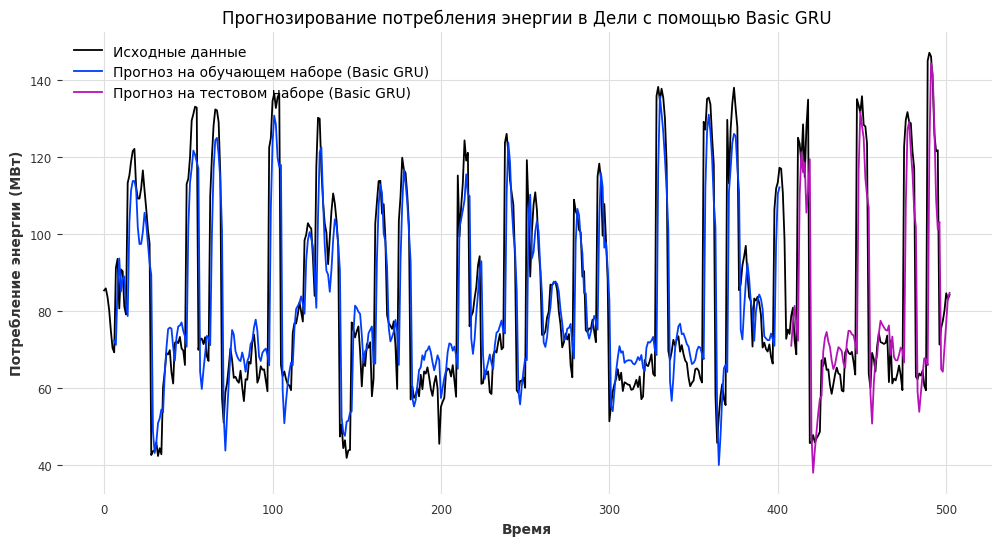

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error

model_gru_basic = Sequential()
model_gru_basic.add(GRU(50, input_shape=(look_back, 1)))
model_gru_basic.add(Dense(1))
model_gru_basic.compile(loss='mean_squared_error', optimizer='adam')

history_gru_basic = model_gru_basic.fit(X_train, Y_train, epochs=30, batch_size=32, validation_data=(X_test, Y_test), verbose=2)

train_predict_gru_basic = model_gru_basic.predict(X_train)
test_predict_gru_basic = model_gru_basic.predict(X_test)

train_predict_gru_basic = scaler_target.inverse_transform(train_predict_gru_basic)
Y_train_actual = scaler_target.inverse_transform(Y_train.reshape(-1, 1))
test_predict_gru_basic = scaler_target.inverse_transform(test_predict_gru_basic)
Y_test_actual = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

train_rmse_gru_basic = np.sqrt(mean_squared_error(Y_train_actual, train_predict_gru_basic))
test_rmse_gru_basic = np.sqrt(mean_squared_error(Y_test_actual, test_predict_gru_basic))
train_mae_gru_basic = mean_absolute_error(Y_train_actual, train_predict_gru_basic)
test_mae_gru_basic = mean_absolute_error(Y_test_actual, test_predict_gru_basic)

print("\nBasic GRU Results:")
print(f"Train RMSE: {train_rmse_gru_basic:.2f}")
print(f"Test RMSE: {test_rmse_gru_basic:.2f}")
print(f"Train MAE: {train_mae_gru_basic:.2f}")
print(f"Test MAE: {test_mae_gru_basic:.2f}")

plt.figure(figsize=(10, 6))
plt.plot(history_gru_basic.history['loss'], label='Ошибка на обучении')
plt.plot(history_gru_basic.history['val_loss'], label='Ошибка на валидации')
plt.title('График обучения Basic GRU')
plt.xlabel('Эпоха')
plt.ylabel('Среднеквадратичная ошибка')
plt.legend()
plt.show()

train_predict_plot = np.empty_like(full_dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict_gru_basic) + look_back, :] = train_predict_gru_basic

test_predict_plot = np.empty_like(full_dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict_gru_basic) + (look_back * 2):len(full_dataset), :] = test_predict_gru_basic

plt.figure(figsize=(12, 6))
plt.plot(scaler_target.inverse_transform(full_dataset), label='Исходные данные')
plt.plot(train_predict_plot, label='Прогноз на обучающем наборе (Basic GRU)')
plt.plot(test_predict_plot, label='Прогноз на тестовом наборе (Basic GRU)')
plt.title('Прогнозирование потребления энергии в Дели с помощью Basic GRU')
plt.xlabel('Время')
plt.ylabel('Потребление энергии (МВт)')
plt.legend()
plt.show()

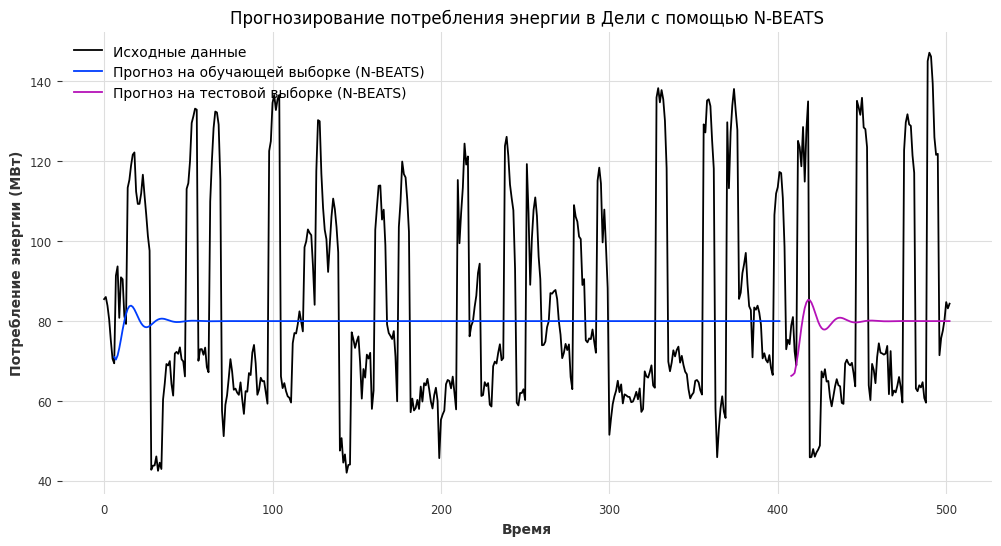

In [ ]:
full_dataset = np.vstack([train_series.values(), test_series.values()])
trainPredictPlot = np.empty_like(full_dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict_nbeats) + look_back, 0] = train_predict_nbeats[:, 0]

testPredictPlot = np.empty_like(full_dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict_nbeats) + (look_back * 2):len(full_dataset), 0] = test_predict_nbeats[:, 0]

plt.figure(figsize=(12, 6))
plt.plot(scaler_target.inverse_transform(full_dataset), label='Исходные данные')
plt.plot(trainPredictPlot, label='Прогноз на обучающей выборке (N-BEATS)')
plt.plot(testPredictPlot, label='Прогноз на тестовой выборке (N-BEATS)')
plt.xlabel('Время')
plt.ylabel('Потребление энергии (МВт)')
plt.title('Прогнозирование потребления энергии в Дели с помощью N-BEATS')
plt.legend()
plt.show()